# _Who has a voice in the media?_

## 1. Pre-processing the dataset
In this study of "_Who has a voice in the media_", the **speaker identity and what it said is vital**. Thus, we remove the following rows from the original dataset:
- rows where either the author or the quotation is NaN; 
- rows where the author has probability lower than 50%. 

Later, we also do a sanity controll and **remove possible duplicate of rows** with the same quote-ID as we obiously don't want to use exactly the same quote more than once in our analyzes. 

Finally, to reduce the dataset further we **remove columns** that we will not use for our analysis: _quoteID_, _speaker_, _probas_, _urls_, _phase_ and _numOccurrences_.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from collections import Counter
from pathlib import Path
# import umap

## 2. Initial analysis
Here, we do initial studies on the content of the dataset. For instance we plot the following information about the speakers:
- occupation;
- gender;
- age;
- ethnicity;
- top 20 speakers.
**OBS! For practical reasons, in the initial analysis in Milestone 2, we randomly picked 100,000 quotations of each year instead of dealing with the whole data. The code and the analysis will basically remain the same but only need to be run for a longer time.**

In [2]:
datafolder = Path("data")

DATA = {
    '2015': 'data/clean-quotes-2015.bz2',
    '2016': 'data/clean-quotes-2016.bz2',
    '2017': 'data/clean-quotes-2017.bz2',
    '2018': 'data/clean-quotes-2018.bz2',
    '2019': 'data/clean-quotes-2019.bz2',
    '2020': 'data/clean-quotes-2020.bz2',
}

ALL_YEARS = ['2015', '2016', '2017', '2018', '2019', '2020']

def load_data(year, sample=True, sample_size=100_000):
    year_file = Path(DATA[year])
    if year_file.exists():
        df = pd.read_csv(DATA[year], compression='bz2')
        if sample:
            df = df.sample(n=sample_size, random_state=1)
    else:
        return None 
    
wikidata_speakers = pd.read_parquet('data/speaker_attributes.parquet')
wikidata_speakers.set_index('id', inplace=True)

In [3]:
nrows = 10_000
df = pd.read_csv(DATA['2020'], compression='bz2', nrows=nrows)

In [4]:
qids = df.qids.tolist()
wanted_qids = [eval(qid)[0] for qid in qids if len(eval(qid)) == 1 and eval(qid)[0] in wikidata_speakers.index]
speakers = wikidata_speakers.loc[wanted_qids]
speakers = speakers[~speakers.index.duplicated(keep='first')]

n_quotes_per_person = Counter(wanted_qids)
speakers['n_quotes'] = speakers.index.map(n_quotes_per_person)

ages = []
for date in speakers.date_of_birth.values:
    if not date is None:
        ages.append(datetime.now().year - int(date[0][1:5]))
    else:
        ages.append(None)

speakers['age'] = ages


### 3. Pre-process dataset
- Only keep meaningful features

In [5]:
speakers.head(5)

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,label,candidacy,type,religion,n_quotes,age
id,,,,,,,,,,,,,,,,
Q367796,None,[+1941-08-01T00:00:00Z],[Q30],[Q6581072],1394911239,None,M001134,[Q82955],[Q29468],None,Sue Myrick,None,item,[Q329646],1,80.0
Q20684375,None,[+1984-09-26T00:00:00Z],None,[Q6581072],1334707378,None,None,None,None,None,Meghan King Edmonds,None,item,None,2,37.0
Q5268447,None,[+1961-05-22T00:00:00Z],[Q23635],[Q6581097],1392562876,None,None,[Q12299841],None,None,Dexter Smith,None,item,None,1,60.0
Q4864119,None,None,None,[Q6581097],1334688923,None,None,None,[Q9630],None,Barry Coppinger,None,item,None,1,NaN
Q816459,"[Benjamin Solomon Carson, Benjamin Solomon ""Be...",[+1951-09-18T00:00:00Z],[Q30],[Q6581097],1387835341,[Q49085],None,"[Q212980, Q9385011, Q82955, Q482980, Q1622272,...","[Q29468, Q29552, Q327591, Q29468]",[Q913404],Ben Carson,None,item,[Q104319],1,70.0


In [6]:
# print(f'The percentage of speakers with US_congress_bio_ID is {100 * len(speakers.US_congress_bio_ID.value_counts().index) / len(speakers.index) :.3f}%')
# print(f'The percentage of speakers with candidacy is {100 * sum(speakers.candidacy.value_counts().values) / len(speakers.index):.3f}%')
# print(f'The percentage of speakers with ethnic_group is {100 * sum(speakers.ethnic_group.value_counts().values) / len(speakers.index):.3f}%')
# print(f'The percentage of speakers with religion is {100 * sum(speakers.religion.value_counts().values) / len(speakers.index):.3f}%')
# print(f'The percentage of speakers with academic_degree is {100 * sum(speakers.academic_degree.value_counts().values) / len(speakers.index):.3f}%')
# print(f'The percentage of speakers with party is {100 * sum(speakers.party.value_counts().values) / len(speakers.index):.3f}%')
# print(f'The percentage of speakers with nationality is {100 * sum(speakers.nationality.value_counts().values) / len(speakers.index):.3f}%')
# print(f'The percentage of speakers with gender is {100 * sum(speakers.gender.value_counts().values) / len(speakers.index):.3f}%')
# print(f'The percentage of speakers with occupation is {100 * sum(speakers.occupation.value_counts().values) / len(speakers.index):.3f}%')


Drop the columns 
- that are particular to the speaker and don't add any value to the clustering (alisaes, label, US_congress_ID) ;
- that don't add value to clustering (lastrevid, type);
- that contain too little data to draw any conclusions (candidacy - 2.9%, academic_degree - 1.3%);
- used to produce the new ages column (date_of_birth). 

In [7]:
speakers_features = speakers.drop(columns=['aliases', 'label', 'US_congress_bio_ID', 
                                           'lastrevid', 'type', 
                                           'candidacy', 'academic_degree', 
                                           'date_of_birth'])
speakers_features.head()

,nationality,gender,ethnic_group,occupation,party,religion,n_quotes,age
id,,,,,,,,
Q367796,[Q30],[Q6581072],None,[Q82955],[Q29468],[Q329646],1,80.0
Q20684375,None,[Q6581072],None,None,None,None,2,37.0
Q5268447,[Q23635],[Q6581097],None,[Q12299841],None,None,1,60.0
Q4864119,None,[Q6581097],None,None,[Q9630],None,1,NaN
Q816459,[Q30],[Q6581097],[Q49085],"[Q212980, Q9385011, Q82955, Q482980, Q1622272,...","[Q29468, Q29552, Q327591, Q29468]",[Q104319],1,70.0


More pre-processing: make the None names to 'Unknown', otherwise the KPrototype doesn't run. This way, the 'Unknown' class becomes a categorical variable.

In [8]:
speakers_features_preprocessed = pd.DataFrame()
speakers_features_preprocessed['n_quotes'] = speakers_features['n_quotes']
speakers_features_preprocessed['age'] = speakers_features['age'].fillna(speakers_features['age'].median())

for name, values in speakers_features.iteritems():
    # Remove all None values from categorical rows, and keep only first instance of list occupation, nationality
    if name not in ['n_quotes', 'age']:
        updated_values = []
        for val in values:
            if not val is None:
                updated_values.append(val[0])
            else:
                updated_values.append('Unknown')
        speakers_features_preprocessed[name] = updated_values
    

In [9]:
speakers_features_preprocessed.head()

,n_quotes,age,nationality,gender,ethnic_group,occupation,party,religion
id,,,,,,,,
Q367796,1,80.0,Q30,Q6581072,Unknown,Q82955,Q29468,Q329646
Q20684375,2,37.0,Unknown,Q6581072,Unknown,Unknown,Unknown,Unknown
Q5268447,1,60.0,Q23635,Q6581097,Unknown,Q12299841,Unknown,Unknown
Q4864119,1,52.0,Unknown,Q6581097,Unknown,Unknown,Q9630,Unknown
Q816459,1,70.0,Q30,Q6581097,Q49085,Q212980,Q29468,Q104319


In [10]:
assert(speakers_features_preprocessed.n_quotes.isna().sum() == 0)
assert(speakers_features_preprocessed.age.isna().sum() == 0)
assert(speakers_features_preprocessed.nationality.isna().sum() == 0)
assert(speakers_features_preprocessed.gender.isna().sum() == 0)
assert(speakers_features_preprocessed.ethnic_group.isna().sum() == 0)
assert(speakers_features_preprocessed.occupation.isna().sum() == 0)
assert(speakers_features_preprocessed.party.isna().sum() == 0)
assert(speakers_features_preprocessed.religion.isna().sum() == 0)

### 4. Cluster with K-prototype

In [11]:
from kmodes.kprototypes import KPrototypes

def plot_sse(features, start=2, end=15):
    sse = []
    for k in range(start, end):
        # Assign the labels to the clusters
        kproto = KPrototypes(n_clusters=k, random_state=10).fit(features, categorical=[2, 3, 4, 5, 6, 7])
        sse.append({"k": k, "sse": kproto.cost_ })

    sse = pd.DataFrame(sse)
    # Plot the data
    plt.plot(sse.k, sse.sse)
    plt.xlabel("K")
    plt.ylabel("Sum of Squared Errors")

In [12]:
# plot_sse(speakers_features_preprocessed)
kproto_2 = KPrototypes(n_clusters=2, random_state=10, n_jobs=-1).fit(speakers_features_preprocessed, categorical=[2, 3, 4, 5, 6, 7])
kproto_3 = KPrototypes(n_clusters=3, random_state=10, n_jobs=-1).fit(speakers_features_preprocessed, categorical=[2, 3, 4, 5, 6, 7])
kproto_4 = KPrototypes(n_clusters=4, random_state=10, n_jobs=-1).fit(speakers_features_preprocessed, categorical=[2, 3, 4, 5, 6, 7])
kproto_5 = KPrototypes(n_clusters=5, random_state=10, n_jobs=-1).fit(speakers_features_preprocessed, categorical=[2, 3, 4, 5, 6, 7])
kproto_6 = KPrototypes(n_clusters=6, random_state=10, n_jobs=-1).fit(speakers_features_preprocessed, categorical=[2, 3, 4, 5, 6, 7])
kproto_7 = KPrototypes(n_clusters=7, random_state=10, n_jobs=-1).fit(speakers_features_preprocessed, categorical=[2, 3, 4, 5, 6, 7])

In [92]:
def get_cluster_points(features, classifications):
    unique_classes = np.unique(classifications)
    list_of_dfs = []
    for label in unique_classes:
        class_filter = np.equal(label, classifications) * 1
        indices = np.nonzero(class_filter)
        df = features.iloc[indices]
        list_of_dfs.append(df)
    return list_of_dfs


In [95]:
list_of_dfs = get_cluster_points(speakers_features_preprocessed, kproto_3.labels_)
list_of_dfs[1]

,n_quotes,age,nationality,gender,ethnic_group,occupation,party,religion
id,,,,,,,,
Q20684375,2,37.0,Unknown,Q6581072,Unknown,Unknown,Unknown,Unknown
Q4864119,1,52.0,Unknown,Q6581097,Unknown,Unknown,Q9630,Unknown
Q30164281,1,36.0,Q145,Q6581097,Unknown,Q82955,Q3243587,Unknown
Q56255401,1,23.0,Q258,Q6581097,Unknown,Q14089670,Unknown,Unknown
Q4749380,1,40.0,Q30,Q6581072,Q678551,Q33999,Unknown,Unknown
...,...,...,...,...,...,...,...,...
Q4941877,1,46.0,Q258,Q6581097,Unknown,Q82955,Q761877,Unknown
Q230815,1,50.0,Q408,Q6581072,Unknown,Q10833314,Unknown,Unknown
Q5232225,1,43.0,Q30,Q6581097,Unknown,Q28389,Unknown,Unknown


In [ ]:
from collections import Counter

In [26]:
print(f'k = 2 --> {Counter(kproto_2.labels_)}')
print(f'k = 3 --> {Counter(kproto_3.labels_)}')
print(f'k = 4 --> {Counter(kproto_4.labels_)}')
print(f'k = 5 --> {Counter(kproto_5.labels_)}')
print(f'k = 6 --> {Counter(kproto_6.labels_)}')
print(f'k = 7 --> {Counter(kproto_7.labels_)}')

k = 2 --> Counter({1: 5439, 0: 2})
k = 3 --> Counter({1: 3406, 0: 2033, 2: 2})
k = 4 --> Counter({3: 2722, 1: 1514, 0: 1203, 2: 2})
k = 5 --> Counter({4: 2338, 1: 1506, 3: 1378, 2: 217, 0: 2})
k = 6 --> Counter({0: 2338, 2: 1404, 5: 1378, 4: 318, 1: 2, 3: 1})
k = 7 --> Counter({6: 2083, 3: 1121, 5: 1095, 0: 954, 1: 185, 4: 2, 2: 1})


Text(0, 0.5, 'Sum of Squared Errors')

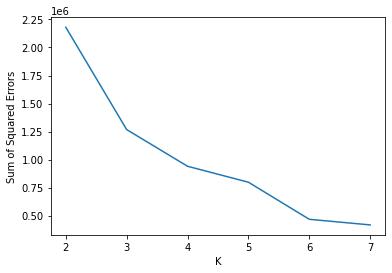

In [27]:
plt.plot([2, 3, 4, 5, 6, 7], [kproto_2.cost_, kproto_3.cost_, kproto_4.cost_, kproto_5.cost_, kproto_6.cost_, kproto_7.cost_])
plt.xlabel("K")
plt.ylabel("Sum of Squared Errors")

### 5. Dimensionality reduction

In [ ]:
# numerical = speakers_features_preprocessed.drop(columns=['nationality', 'gender', 'ethnic_group', 'occupation', 'party', 'religion'])
# categorical = speakers_features_preprocessed.drop(columns=['n_quotes', 'age'])
# categorical = pd.get_dummies(categorical)

# # # # Embedding numerical & categorical
# fit1 = umap.UMAP(metric='l2').fit(numerical)
# fit2 = umap.UMAP(metric='dice').fit(categorical)

# categorical_weight = len(categorical.columns) / (len(categorical.columns) + len(numerical.columns))

# # # Augmenting the numerical embedding with categorical
# intersection = umap.umap_.general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight=categorical_weight)
# intersection = umap.umap_.reset_local_connectivity(intersection)

# embedding = umap.umap_.simplicial_set_embedding(fit1._raw_data, intersection, fit1.n_components, 
#                                                 fit1._initial_alpha, fit1._a, fit1._b, 
#                                                 fit1.repulsion_strength, fit1.negative_sample_rate, 
#                                                 200, 'random', np.random, fit1.metric, 
#                                                 fit1._metric_kwds, False,
#                                                 {}, False)

# plt.figure(figsize=(20, 10))
# plt.scatter(*embedding.T, s=2, cmap='Spectral', alpha=1.0)
# plt.show()

### 6. Visualize clusters

In [ ]:
# from sklearn.manifold import TSNE

# fig, axs = plt.subplots(1, 1, figsize=(4,4), sharey=True)

# # Reduce data to 2 dimensions with t-SNE
# speakers_tsne = TSNE(n_components=2, random_state=0).fit_transform(speakers_features_preprocessed)

# # Plot the data reduced in 2d space with t-SNE
# axs.scatter(speakers_tsne[:,0],  speakers_tsne[:,1],  c=kproto.labels_, alpha=0.6)
# axs.set_title('Predicted labels')